In [1]:
#Importing some necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
#Reading the training and testing files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [3]:
test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


In [4]:
#Knowing the shape of train and test dataset
print('Shape of train is',train.shape,
      '\nShape of test is',test.shape)

Shape of train is (26729, 10) 
Shape of test is (11456, 8)


In [5]:
# list of features
features = list(train.columns)
features


['AnimalID',
 'Name',
 'DateTime',
 'OutcomeType',
 'OutcomeSubtype',
 'AnimalType',
 'SexuponOutcome',
 'AgeuponOutcome',
 'Breed',
 'Color']

## Preprocessing and EDA on training dataset

In [6]:
#checking if there is any null value is present or not
train.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

**Half of the instances in column Outcomesubtype has null values.**

**18 & 1 null values present in sexuponoutcome nd ageuponoutcome respectively won't affect much, so we discard those rows directly.**

In [7]:
#considering only those rows which don't have null values.
train = train[pd.notnull(train['AgeuponOutcome'])]
train = train[pd.notnull(train['SexuponOutcome'])]

In [8]:
#filling null values with unknown category
train.OutcomeSubtype = train.OutcomeSubtype.fillna('unknown')

### Extracting days and years from AgeOutcome and sex from SexuponOutcome 

In [9]:
import re
def convert_to_days(row):
    if (row['AgeuponOutcome'] == '1 year'):
        age = 365
        return age
    elif (row['AgeuponOutcome'] == '1 month'):
        age = 30
        return age
    elif (row['AgeuponOutcome'] == '1 week'):
        age = 7
        return age
    else:
        split = row['AgeuponOutcome'].split(" ")
        period = split[1]
        if (re.search('years',period)):
            per_mod = 365
        elif (re.search('months',period)):
            per_mod = 30
        elif (re.search('weeks', period)):
            per_mod = 7
        else:
            per_mod = 1
    age = int(split[0]) * per_mod
    return age

def label_age(row):
    if (row['AgeuponOutcome'] == '1 year'):
        yr = 1
        return yr
    elif (row['AgeuponOutcome'] == '1 month'):
        yr = 1/12
        return yr
    elif (row['AgeuponOutcome'] == '1 week'):
        yr = 1/48
        return yr
    else:
        split = row['AgeuponOutcome'].split(" ")
        period = split[1]
        if (re.search('years',period)):
            per_mod = 1
        elif (re.search('months',period)):
            per_mod = 1/12
        elif (re.search('weeks', period)):
            per_mod = 1/48
        else:
            per_mod = 1
    yr = int(split[0]) * per_mod
    return yr

def label_sex(row):
    if row['SexuponOutcome'] == 'Unknown':
        sex = 'Unknown'
    else:
        split = row['SexuponOutcome'].split(" ")
        sex = split[1]
    return sex
        

In [10]:
#Applying both on training  dataset
train["Agecat_days"]=train.apply (lambda row: convert_to_days (row),axis=1)
train["Agecat_years"]=train.apply (lambda row: label_age (row),axis=1)
train['sex'] = train.apply( lambda row: label_sex(row) , axis=1)

### Making a new year feature

In [11]:
#Handling datetime column
train.DateTime = pd.to_datetime(train.DateTime)

In [12]:
train['year'] = train.DateTime.dt.year
train['month'] = train.DateTime.dt.month
train['weekday'] = train.DateTime.dt.weekday
train['hour'] = train.DateTime.dt.hour

In [13]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Agecat_days,Agecat_years,sex,year,month,weekday,hour
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,unknown,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,365,1.0000,Male,2014,2,2,18
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,365,1.0000,Female,2013,10,6,12
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,730,2.0000,Male,2015,1,5,12
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,21,0.0625,Male,2014,7,4,19
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,730,2.0000,Male,2013,11,4,12


### How differenct outcomes are distributed

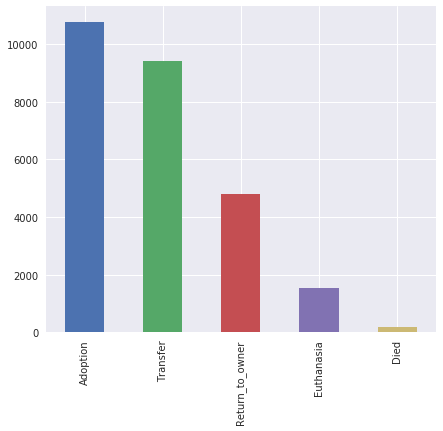

In [14]:
sns.set(rc = {'figure.figsize' : (7,6)})
train.OutcomeType.value_counts().plot(kind = 'bar')

**Observation : Dataset is biased towards the outcome type Adoption and Transfer**

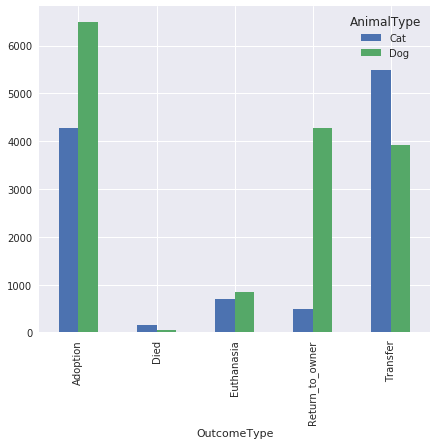

In [15]:
train.groupby('OutcomeType').AnimalType.value_counts().unstack().plot(kind = 'bar')

**Observation: Adoption and trnasfer happens more than others ( good for animal).**

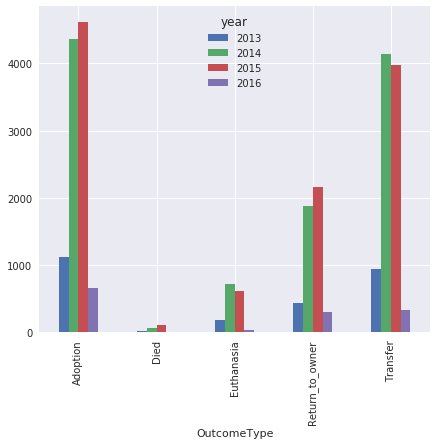

In [16]:
train.groupby('OutcomeType').year.value_counts().unstack().plot(kind = 'bar')

### Relationship between hour of the day and Outcometype

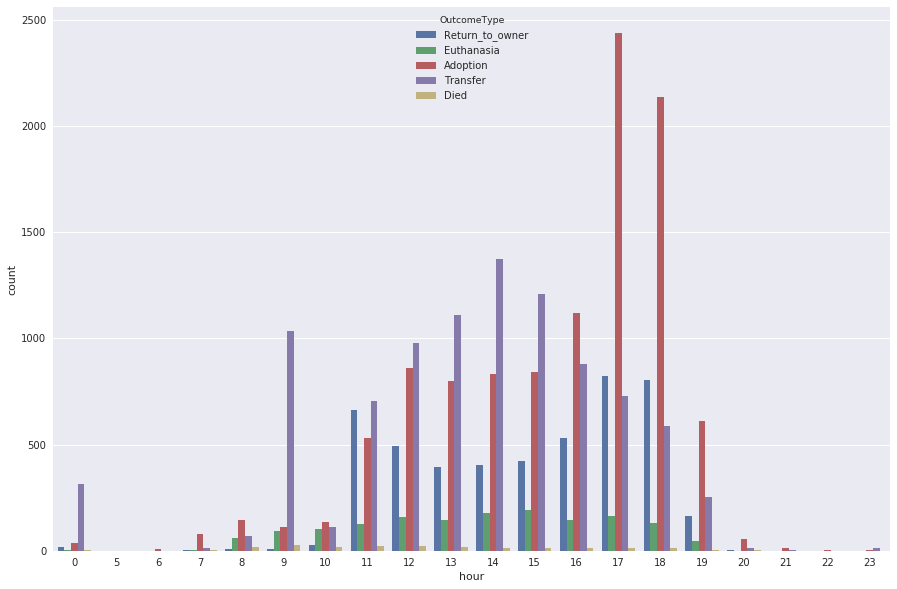

In [17]:
sns.set(rc = {'figure.figsize' : (15,10)})
sns.countplot(data = train,x = 'hour', hue = 'OutcomeType')

**Observation : Arounf 5-6 pm, it is more likely for animal to be adopted whic around 2-3 pm it is more likely to be transfered.**

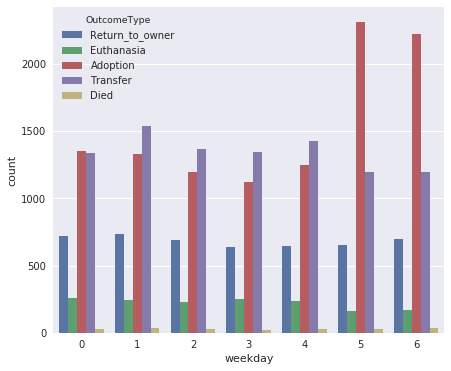

In [18]:
sns.set(rc = {'figure.figsize' : (7,6)})
sns.countplot(data = train,x = 'weekday', hue = 'OutcomeType')

**Observation : Adoption is more likely to happen in weekends**

### Agewise OutcomeType

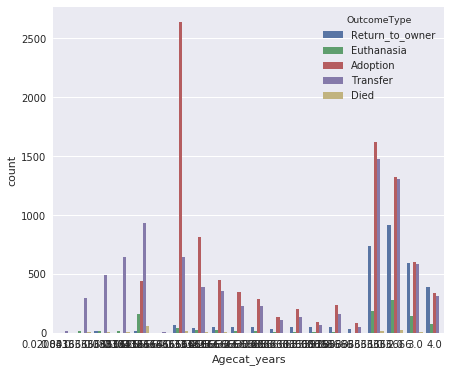

In [19]:
sns.countplot(data = train[train.Agecat_years <= 4.0], x='Agecat_years',hue= 'OutcomeType')

**Observation : Young dogs (older than a month) are likely adopted.**

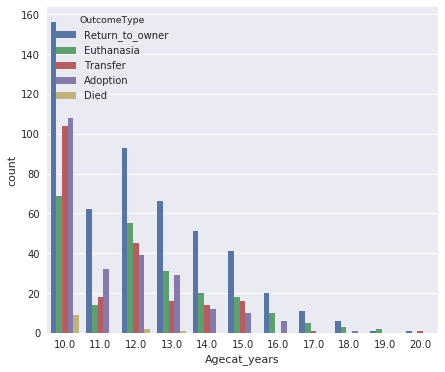

In [20]:
sns.countplot(data = train[train.Agecat_years >= 10.0], x='Agecat_years',hue= 'OutcomeType')

**Old dogs are likely returned to their owner.**

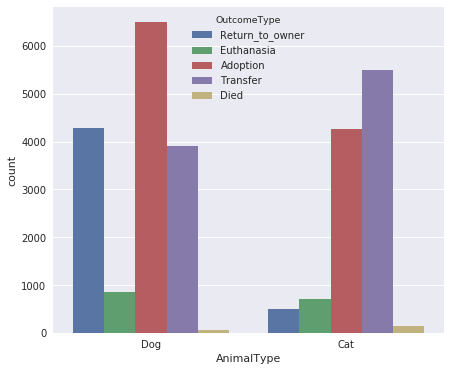

In [21]:
sns.countplot(x = train.AnimalType, hue=train.OutcomeType)

**Dogs in general are more likely to be returned to their owner than cats.**

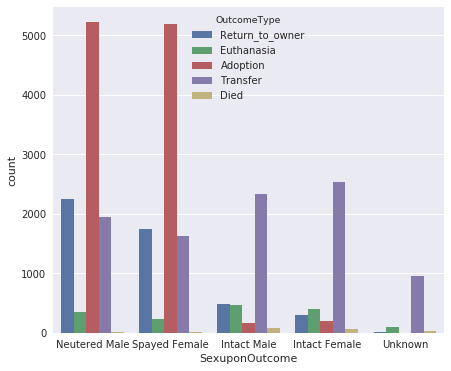

In [22]:
sns.countplot(x = train.SexuponOutcome, hue = train.OutcomeType)

**Neutered males and spayed females are much more likely to get adopted.**

# Preparing training and test data for Classifier

In [23]:
# Prepare for training data
Xtrain = train.drop(["OutcomeType","OutcomeSubtype","AnimalID","Name",'DateTime','Breed','sex'],axis=1)
ytrain = train["OutcomeType"].astype('category').cat.codes

In [24]:
Xtrain.AnimalType = Xtrain.AnimalType.astype('category').cat.codes
Xtrain.SexuponOutcome = Xtrain.SexuponOutcome.astype('category').cat.codes
Xtrain.AgeuponOutcome = Xtrain.AgeuponOutcome.astype('category').cat.codes
Xtrain.Color = Xtrain.Color.astype('category').cat.codes
#Xtrain.sex = Xtrain.sex.astype('category').cat.codes

In [25]:
Xtrain.head()

,AnimalType,SexuponOutcome,AgeuponOutcome,Color,Agecat_days,Agecat_years,year,month,weekday,hour
0,1,2,5,130,365,1.0000,2014,2,2,18
1,0,3,5,167,365,1.0000,2013,10,6,12
2,1,2,21,86,730,2.0000,2015,1,5,12
3,0,1,25,42,21,0.0625,2014,7,4,19
4,1,2,21,274,730,2.0000,2013,11,4,12


In [26]:
#preparing testing data
test.AgeuponOutcome = test.AgeuponOutcome.fillna('1 year')
test["Agecat_days"]=test.apply (lambda row: convert_to_days (row),axis=1)
test["Agecat_years"]=test.apply (lambda row: label_age (row),axis=1)
test['sex'] = test.apply( lambda row: label_sex(row) , axis=1)
test.DateTime = pd.to_datetime(test.DateTime)
test['year'] = test.DateTime.dt.year
test['month'] = test.DateTime.dt.month
test['weekday'] = test.DateTime.dt.weekday
test['hour'] = test.DateTime.dt.hour
Xtest = test.drop(['ID','Name','DateTime','Breed','sex'],axis = 1)
Xtest.AnimalType = Xtest.AnimalType.astype('category').cat.codes
Xtest.SexuponOutcome = Xtest.SexuponOutcome.astype('category').cat.codes
Xtest.AgeuponOutcome = Xtest.AgeuponOutcome.astype('category').cat.codes
Xtest.Color = Xtest.Color.astype('category').cat.codes
#Xtest.sex = Xtest.sex.astype('category').cat.codes
Xtest.head()

,AnimalType,SexuponOutcome,AgeuponOutcome,Color,Agecat_days,Agecat_years,year,month,weekday,hour
0,1,0,6,185,300,0.833333,2015,10,0,12
1,1,3,21,28,730,2.000000,2014,7,5,17
2,0,2,5,79,365,1.000000,2016,1,2,12
3,1,1,29,229,120,0.333333,2013,12,5,18
4,1,2,21,238,730,2.000000,2015,9,3,17


In [27]:
from sklearn.preprocessing import StandardScaler
X_train_std = StandardScaler().fit_transform(Xtrain)
X_test_std = StandardScaler().fit_transform(Xtest)

In [28]:
params = {"objective": "multi:softprob",
          "num_class": 5,
          "eta": 0.1,
          "max_depth": 5,
          "min_child_weight": 3,
          "silent": 1,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "seed": 1}
num_trees=250
%time gbm = xgb.train(params, xgb.DMatrix(X_train_std, ytrain), num_trees)

CPU times: user 36.9 s, sys: 112 ms, total: 37 s
Wall time: 9.35 s


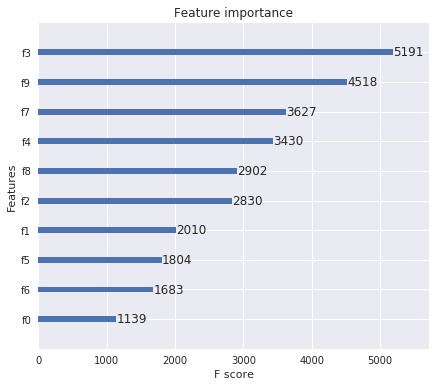

In [29]:
xgb.plot_importance(gbm)

In [30]:
test_probs_xgb = gbm.predict(xgb.DMatrix(X_test_std))

In [31]:
test_probs_xgb

array([[2.33966280e-02, 6.52613631e-03, 2.89336480e-02, 1.67057186e-01,
        7.74086416e-01],
       [8.08356106e-01, 9.31790622e-04, 8.30969308e-03, 1.31969959e-01,
        5.04324771e-02],
       [3.61615747e-01, 1.38062250e-03, 2.72385199e-02, 1.23103224e-01,
        4.86661851e-01],
       ...,
       [1.02057133e-03, 5.08206803e-03, 2.55437661e-02, 1.13260304e-03,
        9.67220962e-01],
       [4.77097571e-01, 1.10361283e-03, 1.75254960e-02, 4.15094912e-01,
        8.91784728e-02],
       [3.69891636e-02, 9.92476474e-04, 1.82314113e-01, 5.69876730e-01,
        2.09827513e-01]], dtype=float32)

In [33]:
submit = pd.DataFrame({
    'ID' : test['ID'],
    'Adoption' : test_probs_xgb[:,0],
    'Died' : test_probs_xgb[:,1],
    'Euthanasia' : test_probs_xgb[:,2],
    'Return_to_owner' : test_probs_xgb[:,3],
    'Transfer' : test_probs_xgb[:,4]
    })
submit.to_csv('shelter.csv', index = False)